In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
import segmentation_models as sm

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Segmentation Models: using `keras` framework.


In [2]:
paths = {
    'train_images' : './dataset/images_prepped_train/',
    'train_labels' : './dataset/annotations_prepped_train/',
    'test_images' : './dataset/images_prepped_test/',
    'test_labels' : './dataset/annotations_prepped_test/'
}

In [3]:
def get_im_paths(path):
    return [path + im for im in os.listdir(path)]

def read_rgb_im(path):
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    #im = cv2.resize(im, (384, 384))
    return im

def read_bin_im(path):
    im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    #im = cv2.resize(im, (384, 384))
    return im

In [4]:
CLASSES = [
    'sky', 'building', 'pole', 'road', 'pavement',
    'tree', 'signsymbol', 'fence', 'car',
    'pedestrian', 'bicyclist', 'unlabelled'
    ]
n_classes = len(CLASSES) + 1

In [5]:
x_train_paths = get_im_paths(paths['train_images'])
y_train_paths = get_im_paths(paths['train_labels'])
x_val_paths = get_im_paths(paths['test_images'])
y_val_paths = get_im_paths(paths['test_labels'])

x_train = np.array([read_rgb_im(path) for path in x_train_paths])
y_train = np.array([read_bin_im(path) for path in y_train_paths])
x_val = np.array([read_rgb_im(path) for path in x_val_paths])
y_val = np.array([read_bin_im(path) for path in y_val_paths])

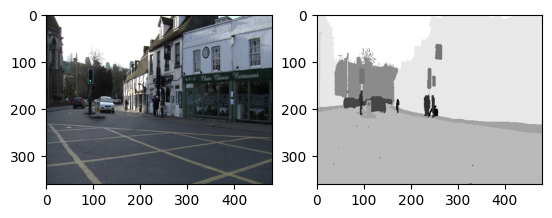

In [6]:
i = 0
plt.subplot(1, 2, 1), plt.imshow(x_train[i])
plt.subplot(1, 2, 2), plt.imshow(y_train[i], 'binary')
plt.show()

In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [8]:
# Dataset for train images
train_dataset = Dataset(
    paths['train_images'], 
    paths['train_labels'], 
    classes=CLASSES
)

# Dataset for validation images
valid_dataset = Dataset(
    paths['test_images'], 
    paths['test_labels'], 
    classes=CLASSES
)

train_dataloader = Dataloder(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [9]:
# define model
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)

model = sm.Unet(BACKBONE, classes=n_classes, activation='softmax')
model.compile(
    optimizer='adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)],
)

58889256/58889256 [==============================] - 19s 0us/step


In [10]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=32, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

/tmp/ipykernel_3944/2128633065.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/32


: 

: 